In [91]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import sympy

### Funções para a extração de dados de arquivos txt para listas de dados

In [92]:
def CarMat(nome):    #Função para carregar uma matriz em txt
    mat = []
    with open(nome) as archivo:
        for linea in archivo:
            A = linea.split( )
            mat.append(A)
    mat = np.array(mat,dtype=object)
    return mat

def StrAFloatList(list):        #para transformar uma lista com strigns a uma lista de floats
    C = list
    B = []
    for i in range(0,len(list)):
        A = float(list[i])
        B.append(A)
    return B

def strAFloatMat(mat):          #para transformar uma matriz com strigns a uma matriz de floats
    C = mat
    B = []
    for i in range(0,len(C[:,0])):
        A = StrAFloatList(C[i,:])
        B.append(A)
    return np.array(B)

### Modelos de Peng - Robinson e Antoine

In [93]:
#Equação de estado de Peng - Robinson
def calcabpr3(t,tc,pc,w,model,palfa):
    r     = 8.314
    ac    = 0.45724*((r*tc)**2)/pc
    b     = 0.0778*r*tc/pc
    tr    = t/tc
    if (model == 'almeida'): #Função de Almeida e Tellez
        alfat = np.exp(palfa[0]*(1-tr)*(abs(1-tr)**(palfa[1]-1))+palfa[2]*(1/tr-1))
    elif (model == 'classico'):
        kw = 0.37464 + 1.54226*w - 0.26992*w**2
        alfat = (1+kw*(1-tr**0.5))**2
    elif (model == 'coquelett'): 
        c1=1.3569*(w**2)+0.9957*w+0.4077;
        c2=-11.298*(w**2)+3.559*w-0.1146;
        c3=11.7801*(w**2)-3.8901*w+0.5033;
        if (t<tc):
            alfat=np.exp(c1*(1-tr))*(((1+c2*(1-tr**0.5)**2+c3*(1-tr**0.5)**3))**2);
        else:
            alfat=np.exp(c1*(1-tr));
    a = ac*alfat
    return a,b

In [94]:
def calcpsatantoine(pa,t):
    a = pa[0]
    b = pa[1]
    c = pa[2]
    psat  = 10**(a-b/(t+c))
    psata = psat*1E5
    return psata

### Rotina para cálculo de $P^{sat}$

In [95]:
#Rotina para cálculo da pressão de saturação do Sandler
def calculaelvfipr(t,a,b,chute0):
    [zl,zv,A,B] = resolveeospr2(a,b,t,chute0)
    [fiv,fil]   = calcfipr2(A,B,zl,zv)
    r   = 8.314
    rfi = fiv/fil
    dfi = 1-rfi
    tol = 1e-10 #tolerância
    while np.any(abs(dfi)>=tol):
        chute1 = chute0/rfi
        [zl,zv,A,B] = resolveeospr2(a,b,t,chute1)
        [fiv,fil]   = calcfipr2(A,B,zl,zv)
        rfi = fiv/fil
        dfi = 1-rfi
        chute0 = chute1
    plv = chute0
    fv  = plv*fiv
    return plv,fv

In [96]:
#Coeficientes de fugacidade a partir do modelo de Peng - Robinson
def calcfipr2(A,B,zl,zv):
    fil = np.exp(zl-1-np.log(zl-B) + (A/(B*(2**1.5)))*np.log((zl+B*(1-2**0.5))/(zl+B*(1+2**0.5))))
    fiv = np.exp(zv-1-np.log(zv-B) + (A/(B*(2**1.5)))*np.log((zv+B*(1-2**0.5))/(zv+B*(1+2**0.5))))
    return fiv,fil

In [97]:
#Função para resolver a forma cúbica de Peng - Robinson
def resolveeospr2(a, b, t, chute):
    r    = 8.31451
    A    = a * chute / ((r * t) ** 2)
    B    = b * chute / (r * t)
    alfa = B - 1
    beta = A - 3 * (B ** 2) - 2 * B
    gama =-A * B + B ** 2 + B ** 3
    p=[1,alfa,beta,gama]
    vz=np.roots(p)
    zl=np.real(min(vz))
    zv=np.real(max(vz))
    return zl, zv, A, B

In [98]:
#Função para o cálculo de Psat via PR
def calcpsatpr(t, tc, pc, w, lambdaA, paA):
    tcalc = t
    apr     = calcabpr3(tcalc,tc, pc, w, 'almeida', lambdaA) [0]
    bpr     = calcabpr3(tcalc,tc, pc, w, 'almeida', lambdaA) [1]
    psatA   = calcpsatantoine(paA, tcalc)
    chutepr = psatA
    psatPR,fsat  = calculaelvfipr(tcalc, apr, bpr, chutepr)
    return psatPR,fsat

### Modelagem do ELV via abordagem fi - fi

In [99]:
#Regras de mistura para o modelo de Peng-Robinsoon
def calcab(x1,x2,t,p,ai,bi,x0):
    r   = 8.314
    d12 = x0 #parâmetro de interação binário
    a12 = (1-d12)*(ai[0]*ai[1])**(1/2)
    am  = x1**2*ai[0] + 2*x1*x2*a12 + x2**2*ai[1]
    bm  = x1*bi[0] + x2*bi[1]
    A   = am*p/(r*t)**2
    B   = bm*p/(r*t)
    return A, B, am, bm

In [100]:
#Função para o cálculo de coeficientes de fugacidade via 
def calcfipr(A,B,zv,ai,bi,a,b,x1,x2,ncomp,x0):
    coefug = np.zeros(ncomp)
    d12    = x0
    a12    = (1-d12)*(ai[0]*ai[1])**(1/2)
    
    p11 = (bi[0]/b)*(zv-1)-np.log(zv-B)
    p12 = A/(2*2**0.5*B)
    p13 = 2*(x1*ai[0] + x2*a12)/a - bi[0]/b
    p14 = np.log((zv + (1 + 2**0.5)*B)/(zv + (1 - 2**0.5)*B))
    coefug1 = np.exp(p11 - p12*p13*p14)
    
    p21 = (bi[1]/b)*(zv-1)-np.log(zv-B)
    p22 = A/(2*2**0.5*B)
    p23 = 2*(x2*ai[1] + x1*a12)/a - bi[1]/b
    p24 = np.log((zv + (1 + 2**0.5)*B)/(zv + (1 - 2**0.5)*B))
    coefug2 = np.exp(p21 - p22*p23*p24)
    
    return np.array([coefug1,coefug2])

In [101]:
#Rotina para o cálculo de coeficientes de fugacidade na fase vapor
def calcoefugv(y1,y2,t,p,vtcpcw,vlambda,x0):
    ncomp = 2
    palfa = vlambda
    tc = vtcpcw[:,0]
    pc = vtcpcw[:,1]
    w  = vtcpcw[:,2]

    ai = np.zeros(ncomp)
    bi = np.zeros(ncomp)

    for i in range(0,ncomp):
        ai[i],bi[i] = calcabpr3(t,tc[i],pc[i],w[i],'almeida',palfa[i,:])
        

    am,bm     = calcab(y1,y2,t,p,ai,bi,x0)[2:4]
    zl,zv,A,B = resolveeospr2(am,bm,t,p)
    coefug    = calcfipr(A,B,zv,ai,bi,am,bm,y1,y2,ncomp,x0)
    return coefug

In [102]:
#Rotina para o cálculo de coeficientes de fugacidade na fase líquida
def calcoefugl(x1,x2,t,p,vtcpcw,vlambda,x0):
    ncomp = 2
    palfa = vlambda
    tc = vtcpcw[:,0]
    pc = vtcpcw[:,1]
    w  = vtcpcw[:,2]

    ai = np.zeros(ncomp)
    bi = np.zeros(ncomp)

    for k in range(0,ncomp):
        ai[k],bi[k] = calcabpr3(t,tc[k],pc[k],w[k],'almeida',palfa[k,:])

    am,bm = calcab(x1,x2,t,p,ai,bi,x0)[2:4]

    zl,zv,A,B = resolveeospr2(am,bm,t,p)

    coefug = calcfipr(A,B,zl,ai,bi,am,bm,x1,x2,ncomp,x0)
    return coefug

In [103]:
#Função para o cálculo da pressão de bolha via abordagem fi - fi com modelo de Peng - Robinson
def calcpbrealbinfifipr(z,t,pv,vtcpcw,vlambda,x0):
    ncomp = 2
    eps   = 1e-5
    dy    = 1
    dfi1  = 1
    dfi2  = 1

    yid = np.zeros(ncomp)
    
    z   = np.array(z)
    pv  = np.array(pv)
    
    pb0 = z[0]*pv[0]+z[1]*pv[1] #chute inicial para Pb via Lei de Rault
    
    for i in range(ncomp):
        yid[i]=z[i]*pv[i]/pb0 #chute inicial para a composição na fase vapor via Lei de Rault
    
    y10 = yid[0]
    y20 = yid[1]

    while (dy>=eps):
        coefugl = calcoefugl(z[0],z[1],t,pb0,vtcpcw,vlambda,x0)
        while (dfi1>=eps) or (dfi2>=eps):
            #avaliando o equilíbrio para o componente 1
            coefugv = calcoefugv(y10,y20,t,pb0,vtcpcw,vlambda,x0)
            rfi1 = (z[0]*coefugl[0])/(y10*coefugv[0])
            y1   = y10*rfi1
            y10  = y1
            dfi1 = (rfi1-1)**2
            
            #avaliando o equilíbrio para o componente 2
            coefugv = calcoefugv(y10,y20,t,pb0,vtcpcw,vlambda,x0)
            rfi2 = (z[1]*coefugl[1])/(y20*coefugv[1])
            y2   = y20*rfi2
            y20  = y2
            dfi2 = (rfi2-1)**2
        
        #testando a solução encontrada para o equilíbrio
        s   = y10 + y20
        pb0 = pb0*s #atualizando a pressão de bolha inicial
        dy  = abs(s-1)
        y   = [y10,y20]
        
        dfi1 = 1
        dfi2 = 1
    
    pb = pb0
    
    return pb,y

In [104]:
#Função para o cálculo do diagrama de fases no espaço P - z na abordagem fi - fi via PR e lei de Rault
def calcdiagpbfifi(t,ncomp,vtcpcw,vlambda,mPA,xf):
    
    ncomp=2
    pv=np.zeros(ncomp)
    fsat=np.zeros(ncomp)
    
    #definindo os lambdas dos componentes
    lambdaA=vlambda[0]
    lambdaB=vlambda[1]
    
    n = 200 #número de pontos do diagrama
    pcalc  = np.zeros(n)
    ycalc  = np.zeros(n)
    pcalcid = np.zeros(n)
    ycalcid = np.zeros(n)
    
    #calculando os psats dos componentes puros
    pv[0],fsat[0] = calcpsatpr(t,vtcpcw[0][0],vtcpcw[0][1],vtcpcw[0][2],lambdaA,mPA[0])
    pv[1],fsat[1] = calcpsatpr(t,vtcpcw[1][0],vtcpcw[1][1],vtcpcw[1][2],lambdaB,mPA[1])
    pcalc[-1] = pv[0]
    pcalc[0]  = pv[1]
    pcalcid[-1] = pv[0]
    pcalcid[0] = pv[1]
   
    z1calc = np.linspace(0.0000000000000001,0.999999999999999,n)
    z2calc = [1-x for x in z1calc]
    
    for i in range (n):
        z=[z1calc[i],z2calc[i]]
        pcalcid[i]= z1calc[i]*pv[0]+z2calc[i]*pv[1]
        pcalc[i], y0 = calcpbrealbinfifipr(z,t,pv,vtcpcw,vlambda,xf)
        ycalc[i]= y0[0]
        ycalcid[i] = z1calc[i]*pv[0]/pcalcid[i]
        
    return z1calc,ycalc,ycalcid,pcalc,pcalcid,pv

### Carrega de dados de compostos puros

In [105]:
vTcPcw       = CarMat("TcPcw.txt")
Antoine      = CarMat("Antoine.txt")
Lambda       = CarMat("Lambdas.txt")

### Diagrama de fase do sistema éter dietílico - acetona via abordagem fi - fi

In [106]:
#definindo parâmetros de Antoine, lambdas e propriedades crítica do dietil-éter
paAdet  = StrAFloatList(Antoine[5][0:3])
Lambdadet = StrAFloatList(Lambda[5][0:3])
vTcPcwdet = StrAFloatList(vTcPcw[5][0:3])

In [107]:
#definindo parâmetros de Antoine, lambdas e propriedades críticas para acetona
paAac = StrAFloatList(Antoine[1][0:3])
Lambdaac = StrAFloatList(Lambda[1][0:3])
vTcPcwac = StrAFloatList(vTcPcw[1][0:3])

In [108]:
#Definindo matrizes de lambdas e propriedades críticas
vtcpcw1=np.array([vTcPcwdet,vTcPcwac])
vlambda1=np.array([Lambdadet,Lambdaac])
mPA1=np.array([paAdet,paAac])

In [109]:
#carregando dados ELV para o sistema Acetona - éter dietílico
dadoselv1 = CarMat("dadoselv - dietil eter - acetona.txt")
dadoselv1 = strAFloatMat(dadoselv1)
pexp1  = np.array(dadoselv1[:,0])*1000
zexp1 = np.array(dadoselv1[:,1])
yexp1 = np.array(dadoselv1[:,2])

In [110]:
#Cálculo do diagrama de fases do sistema Acetona - Éter - dietílico
t=303.15
ncomp=2
xf=0.03880447
z1calc,y1calc,y1calcid,pcalcpr1,pcalcid1,pv1=calcdiagpbfifi(t,ncomp,vtcpcw1,vlambda1,mPA1,xf)

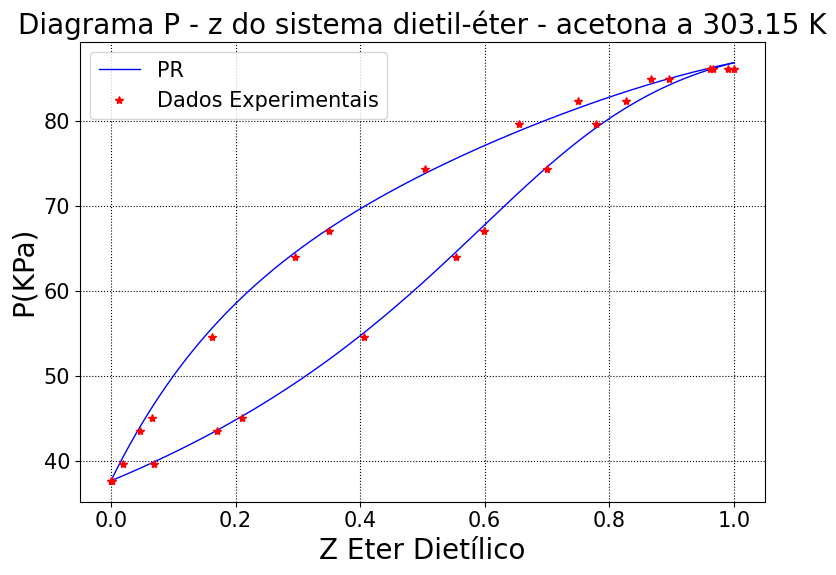

In [111]:
#plot do diagrama de fases via abordagem fi - fi
plt.figure(figsize=(8,6))
plt.plot(z1calc,pcalcpr1/1000,color="blue", linewidth=1, label = 'PR')
plt.plot(y1calc,pcalcpr1/1000,color="blue", linewidth=1)
plt.plot(zexp1,pexp1/1000,color="red", marker = "*", linewidth=0, label = 'Dados Experimentais')
plt.plot(yexp1,pexp1/1000,color="red", marker = "*", linewidth = 0)
plt.xlabel('Z Eter Dietílico',fontsize=20)
plt.ylabel('P(KPa)',fontsize=20)
plt.title('Diagrama P - z do sistema dietil-éter - acetona a 303.15 K', fontsize = 20)
plt.rcParams.update({'font.size':15})
plt.legend()
plt.grid(True, color='k', linestyle=':')
plt.tight_layout()
plt.savefig('ELV EterDietílico-Acetona.png',dpi=600)
plt.show()

In [112]:
dadoselv12 = CarMat("dadoselv - dietil eter - acetona2.txt")
dadoselv12 = strAFloatMat(dadoselv12)
pexp12  = np.array(dadoselv12[:,0])*1000
zexp12 = np.array(dadoselv12[:,1])
yexp12 = np.array(dadoselv12[:,2])

In [113]:
#Cálculo dos desvios relativos médios na pressão e composição da fase vapor
nexp12=len(zexp12)

vpexp12=[float(x) for x in pexp12] #criando um vetor numérico (string para float)
vyexp12=[float(x) for x in yexp12]

erropb  = np.zeros(nexp12)
erroyb = np.zeros(nexp12)

erromediopb=0;
erromedioyb=0;

for i in range(nexp12):
    z=[zexp12[i],1-zexp12[i]]
    pbpr, y0 = calcpbrealbinfifipr(z,t,pv1,vtcpcw1,vlambda1,xf)
    ybpr = y0[0]
    erropb[i]=abs(vpexp12[i]-pbpr)/vpexp12[i]
    erroyb[i]=abs(vyexp12[i]-ybpr)/vyexp12[i]
    erromediopb=erromediopb+erropb[i]
    erromedioyb=erromedioyb+erroyb[i]

erromediopb=erromediopb/nexp12
erromedioyb=erromedioyb/nexp12

print('erro medio Pb=',erromediopb)
print('erro medio yb=',erromedioyb)

erro medio Pb= 0.011931565401175513
erro medio yb= 0.04797258894104979


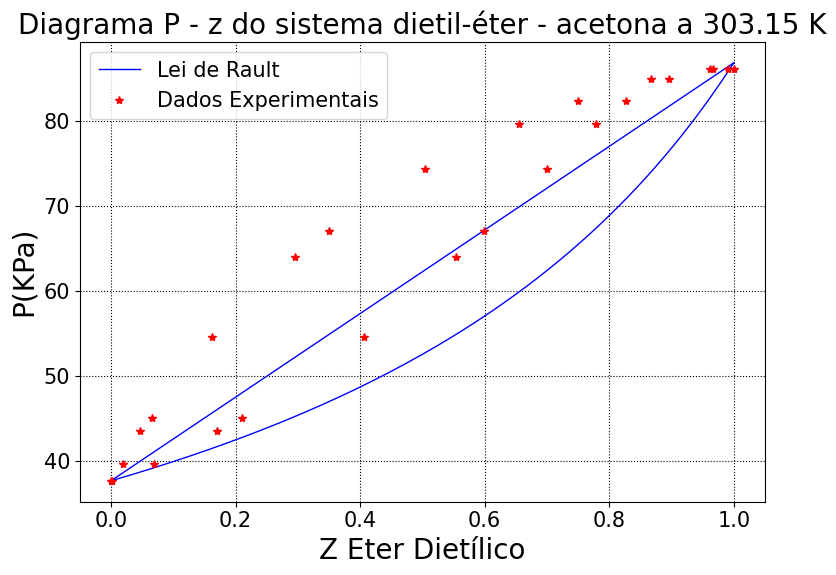

In [114]:
#plot do diagrama de fases via lei de Rault
plt.figure(figsize=(8,6))
plt.plot(z1calc,pcalcid1/1000,color="blue", linewidth=1, label = 'Lei de Rault')
plt.plot(y1calcid,pcalcid1/1000,color="blue", linewidth=1)
plt.plot(zexp1,pexp1/1000,color="red", marker = "*", linewidth=0, label = 'Dados Experimentais')
plt.plot(yexp1,pexp1/1000,color="red", marker = "*", linewidth = 0)
plt.xlabel('Z Eter Dietílico',fontsize=20)
plt.ylabel('P(KPa)',fontsize=20)
plt.title('Diagrama P - z do sistema dietil-éter - acetona a 303.15 K', fontsize = 20)
plt.rcParams.update({'font.size':15})
plt.legend()
plt.grid(True, color='k', linestyle=':')
plt.tight_layout()
plt.savefig('ELV EterDietílico-Acetona.png',dpi=600)
plt.show()

### Modelagem do diagrama de fases do sistema dieteil - éter - metanol via abordagem fi-fi

In [115]:
paAmet = StrAFloatList(Antoine[6][0:3])
Lambdamet = StrAFloatList(Lambda[6][0:3])
vTcPcwmet = StrAFloatList(vTcPcw[6][0:3])

In [116]:
vtcpcw2=np.array([vTcPcwdet,vTcPcwmet])
vlambda2=np.array([Lambdadet,Lambdamet])
mPA2=np.array([paAdet,paAmet])

In [117]:
dadoselv2 = CarMat("dadoselv - dietileter - metanol.txt")
dadoselv2 = strAFloatMat(dadoselv2)
pexp2  = np.array(dadoselv2[:,0])*1000
zexp2 = np.array(dadoselv2[:,1])
yexp2 = np.array(dadoselv2[:,2])

In [118]:
t=303.15
ncomp=2
xf=-0.02162723
z2calc,y2calc,y2calcid,pcalcpr2,pcalcid2,pv2=calcdiagpbfifi(t,ncomp,vtcpcw2,vlambda2,mPA2,xf)

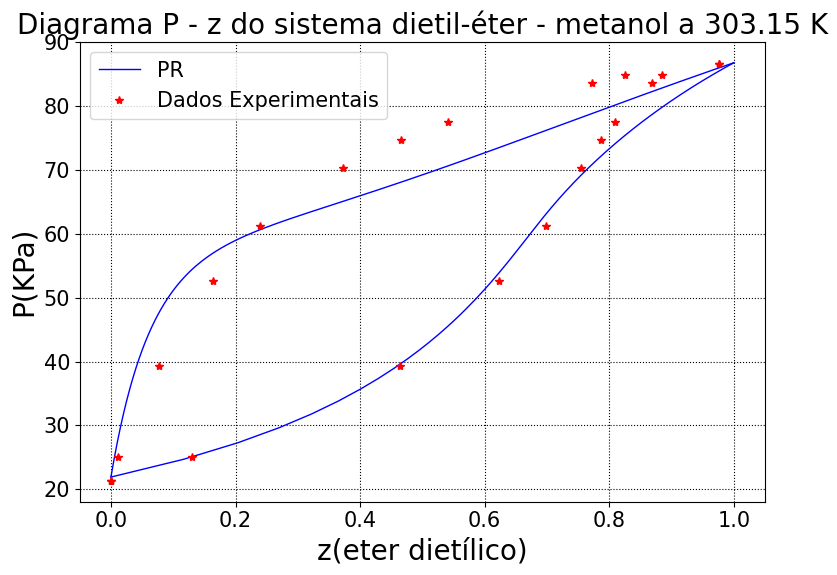

In [119]:
#plot do diagrama de fases via abordagem fi - fi
plt.figure(figsize=(8,6))
plt.plot(z2calc,pcalcpr2/1000,color="blue", linewidth=1, label = 'PR')
plt.plot(y2calc,pcalcpr2/1000,color="blue", linewidth=1)
plt.plot(zexp2,pexp2/1000,color="red", marker = "*", linewidth=0, label = 'Dados Experimentais')
plt.plot(yexp2,pexp2/1000,color="red", marker = "*", linewidth = 0)
plt.xlabel('z(eter dietílico)',fontsize=20)
plt.ylabel('P(KPa)',fontsize=20)
plt.title('Diagrama P - z do sistema dietil-éter - metanol a 303.15 K', fontsize = 20)
plt.rcParams.update({'font.size':15})
plt.legend()
plt.grid(True, color='k', linestyle=':')
plt.tight_layout()
plt.savefig('ELV EterDietílico-metanol.png',dpi=600)
plt.show()

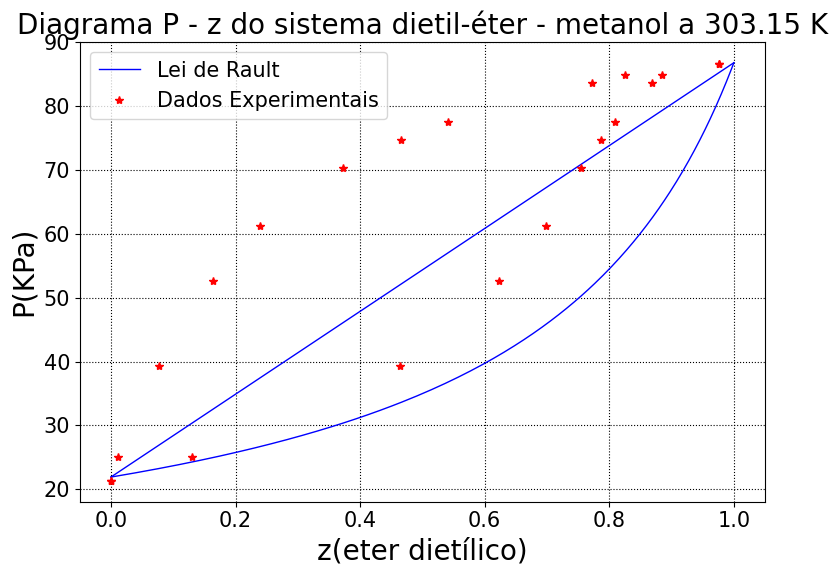

In [120]:
#plot do diagrama de fases via lei de Rault
plt.figure(figsize=(8,6))
plt.plot(z2calc,pcalcid2/1000,color="blue", linewidth=1, label = 'Lei de Rault')
plt.plot(y2calcid,pcalcid2/1000,color="blue", linewidth=1)
plt.plot(zexp2,pexp2/1000,color="red", marker = "*", linewidth=0, label = 'Dados Experimentais')
plt.plot(yexp2,pexp2/1000,color="red", marker = "*", linewidth = 0)
plt.xlabel('z(eter dietílico)',fontsize=20)
plt.ylabel('P(KPa)',fontsize=20)
plt.title('Diagrama P - z do sistema dietil-éter - metanol a 303.15 K', fontsize = 20)
plt.rcParams.update({'font.size':15})
plt.legend()
plt.grid(True, color='k', linestyle=':')
plt.tight_layout()
plt.savefig('ELV EterDietílico-metanol.png',dpi=600)
plt.show()

In [121]:
#Cálculo dos desvios relativos médios na pressão e composição da fase vapor
nexp2=len(zexp2)

vpexp2=[float(x) for x in pexp2] #criando um vetor numérico (string para float)
vyexp2=[float(x) for x in yexp2]

erropb  = np.zeros(nexp2)
erroyb = np.zeros(nexp2)

erromediopb=0;
erromedioyb=0;

for i in range(nexp2):
    z=[zexp2[i],1-zexp2[i]]
    pbpr, y0 = calcpbrealbinfifipr(z,t,pv2,vtcpcw2,vlambda2,xf)
    ybpr = y0[0]
    erropb[i]=abs(vpexp2[i]-pbpr)/vpexp2[i]
    erroyb[i]=abs(vyexp2[i]-ybpr)/vyexp2[i]
    erromediopb=erromediopb+erropb[i]
    erromedioyb=erromedioyb+erroyb[i]

erromediopb=erromediopb/nexp2
erromedioyb=erromedioyb/nexp2

print('erro medio Pb=',erromediopb)
print('erro medio yb=',erromedioyb)

erro medio Pb= 0.07556351340541544
erro medio yb= 2.4982013355081536


### Modelagem do diagrama de fases do sistema benzeno - etanol via abordagem gama - fi (Peng - Robinson e UNIQUAC)

In [122]:
#função para construção de diagramas de fases P - z na abordagem gama - fi
def calcdiagpb(t,vtcpcw,vlambda,mrq,mPA,x0):
    ncomp=2
    pv=np.zeros(ncomp)
    fsat=np.zeros(ncomp)
    
    #definindo os lambdas dos componentes
    lambdaA=vlambda[0]
    lambdaB=vlambda[1]
    
    pv[0],fsat[0] = calcpsatpr(t,vtcpcw[0][0],vtcpcw[0][1],vtcpcw[0][2],lambdaA,mPA[0])
    pv[1],fsat[1] = calcpsatpr(t,vtcpcw[1][0],vtcpcw[1][1],vtcpcw[1][2],lambdaB,mPA[1])
    
    n=300 #número de pontos no diagrama de fases
    z1calc = np.linspace(0.0000000000000001,0.999999999999999,n)
    z2calc = [1-x for x in z1calc]
    
    pbcalc=np.zeros(n)
    ycalc=np.zeros(n)
    
    for i in range (n):
        z=[z1calc[i],z2calc[i]]
        pbcalc[i],y0 = calcpbreal(z,t,pv,fsat,vtcpcw,vlambda,mrq,x0,ncomp)
        ycalc[i]= y0[0]
        
        
    return z1calc,ycalc,pbcalc,pv,fsat

In [123]:
#função para o cálculo da pressão de bolha na abordagem gama - fi com modelos de Peng - Robinson e UNIQUAC
def calcpbreal(z,t,pv,fsat,vtcpc,vlambda,mrq,x0,ncomp):
    eps    = 1e-5
    epsy   = 1e-5
    dy     = 1
    dgama1 = 1
    dgama2 = 1
    
    pb0 = z[0]*pv[0] + z[1]*pv[1]
    
    yid1 = z[0]*pv[0]/pb0
    yid2 = z[1]*pv[1]/pb0
    
    y10 = yid1
    y20 = yid2
    
    gama = calcgamauni(z[0],z[1],t,mrq,x0) #Cálculo dos coeficientes de fugacidade via UNIQUAC
    
    while (np.any(dy >= epsy)):
        zv,ai,bi = calculazv(z[0],z[1],t,pb0,vtcpc,vlambda)
        while (np.any(dgama1 >= eps)) or (np.any(dgama2 >= eps)):
            coefug = calcoefug(y10,y20,zv,ai,bi,t,pb0,ncomp)
            rgama2 = (z[1]*gama[1]*fsat[1])/(y20*pb0*coefug[1])
            dgama2 = (rgama2-1)**2
            y20    = y20*rgama2
            
            coefug = calcoefug(y10,y20,zv,ai,bi,t,pb0,ncomp)
            rgama1 = (z[0]*gama[0]*fsat[0])/(y10*pb0*coefug[0])
            dgama1 = (rgama1-1)**2
            y10    = y10*rgama1
        
        s   = (y10+y20)
        pb0 = pb0*s
        dy  = abs(s-1)
        y   = [y10,y20]
        dgama1 = 1
        dgama2 = 1
    
    pb = pb0
    
    return pb, y

In [124]:
#função para o cálculo do fator de compressibilidade para a fase vapor
def calculazv(z1,z2,t,p,vtcpc,vlambda):
    ncomp = 2
    palfa = vlambda
    
    Tc = vtcpc[:,0]
    Pc = vtcpc[:,1]
    w  = vtcpc[:,2]
    ai = np.zeros(ncomp)
    bi = np.zeros(ncomp)

    for i in range(0,ncomp):
            ai[i],bi[i] = calcabpr3(t,Tc[i],Pc[i],w,'almeida',palfa[i,:])
            
    
    am, bm   = calcab(z1,z2,t,p,ai,bi,0)[2:4]
    zl, zv, A, B = resolveeospr2(am,bm,t,p)
    return zv, ai, bi

In [125]:
#função para o cálculo dos coeficientes de fugacidade na fase vapor
def calcoefug(x1,x2,zv,ai,bi,t,p,ncomp):
    A,B,am,bm = calcab(x1,x2,t,p,ai,bi,0)
    coefug    = calcfipr(A,B,zv,ai,bi,am,bm,x1,x2,ncomp,0)
    return coefug

In [126]:
#Função para o cálculo de coeficientes de atividade via UNIQUAC
def calcgamauni(x10,x20,t,mrq,x0):
    lngamacomb = np.zeros(2)
    lngamares  = np.zeros(2)
    gama       = np.zeros(2)
    fi         = np.zeros(2)
    teta       = np.zeros(2)
    tal        = np.zeros(2)
    l          = np.zeros(2)
    u          = np.zeros(2)
    
    #número de primeiros vizinhos da rede
    zconf = 8
    
    #parâmetros uniquac - r e q
    r1 = mrq[0,0]
    q1 = mrq[0,1]
    r2 = mrq[1,0]
    q2 = mrq[1,1]
    
    #frações de segmentos
    fi1 = (r1*x10)/(r1*x10+r2*x20)
    fi2 = (r2*x20)/(r1*x10+r2*x20)
    
    #frações de área de contato
    teta1 = (q1*x10)/(q1*x10+q2*x20)   
    teta2 = (q2*x20)/(q1*x10+q2*x20)
    
    l1 = (zconf/2)*(r1-q1)-(r1-1)
    l2 = (zconf/2)*(r2-q2)-(r2-1)
    
    #parâmetros energéticos uniquac - uij e uji
    u12_0 = x0[0]
    u21_0 = x0[1]

    u21_t = x0[2]
    u12_t = x0[3]

    u[0] = u12_0 + u12_t*(t-298.15)
    u[1] = u21_0 + u21_t*(t-298.15)

    tal[0] = np.exp(-u[0]/t)
    tal[1] = np.exp(-u[1]/t)
    
    #cálculo dos coeficientes de atividade
    lngamacomb1 = np.log(fi1/x10) - zconf/2*q1*np.log(fi1/teta1)+l1-fi1/x10*(x10*l1+x20*l2)
    lngamacomb2 = np.log(fi2/x20) - zconf/2*q2*np.log(fi2/teta2)+l2-fi2/x20*(x10*l1+x20*l2)
    
    lngamares1 = q1*(1-np.log(teta1+teta2*tal[1])-(teta1/(teta1+teta2*tal[1])+(teta2*tal[0])/(teta2+teta1*tal[0])))
    lngamares2 = q2*(1-np.log(teta2+teta1*tal[0])-(teta2/(teta2+teta1*tal[0])+(teta1*tal[1])/(teta1+teta2*tal[1])))
    
    gama1 = np.exp(lngamacomb1+lngamares1)
    gama2 = np.exp(lngamacomb2+lngamares2)
    
    return np.array([gama1,gama2])

In [127]:
#lendo dados para o Benzeno
paAb  = StrAFloatList(Antoine[2][0:3])
Lambdab = StrAFloatList(Lambda[2][0:3])
vTcPcwb= StrAFloatList(vTcPcw[2][0:3])

In [128]:
#lendo dados para o etanol
paAet  = StrAFloatList(Antoine[4][0:3])
Lambdaet = StrAFloatList(Lambda[4][0:3])
vTcPcwet= StrAFloatList(vTcPcw[4][0:3])

In [129]:
#Lendo as matrizes com dados ELV e dados mrq
dadoselv3 = CarMat("dadoselv - benzeno - etanol2.txt") #dados sem componentes puros
dadoselv3 = strAFloatMat(dadoselv3)
mrq3      = CarMat("mrq - etanol - benzeno.txt")
mrq3      = strAFloatMat(mrq3)

In [130]:
pexp3  = np.array(dadoselv3[:,0])*1000
zexp3 = dadoselv3[:,1]
yexp3 = np.array(dadoselv3[:,2])

In [131]:
#Lendo os dados dos componentes 
vTcPcw3   = np.array([vTcPcwet,vTcPcwb])
vlambda3  = np.array([Lambdaet,Lambdab])
mpA3 = np.array([paAet,paAb])

In [132]:
#Calculo do diagrama P - z do sistema benzeno - etanol
t=318.15
xf=[298.78201846, 405.84363675, 2.48033063, -19.6078529]
zcalc3,ycalc3,pbprcalc3,pv3,fsat3=calcdiagpb(t,vTcPcw3,vlambda3,mrq3,mpA3,xf)

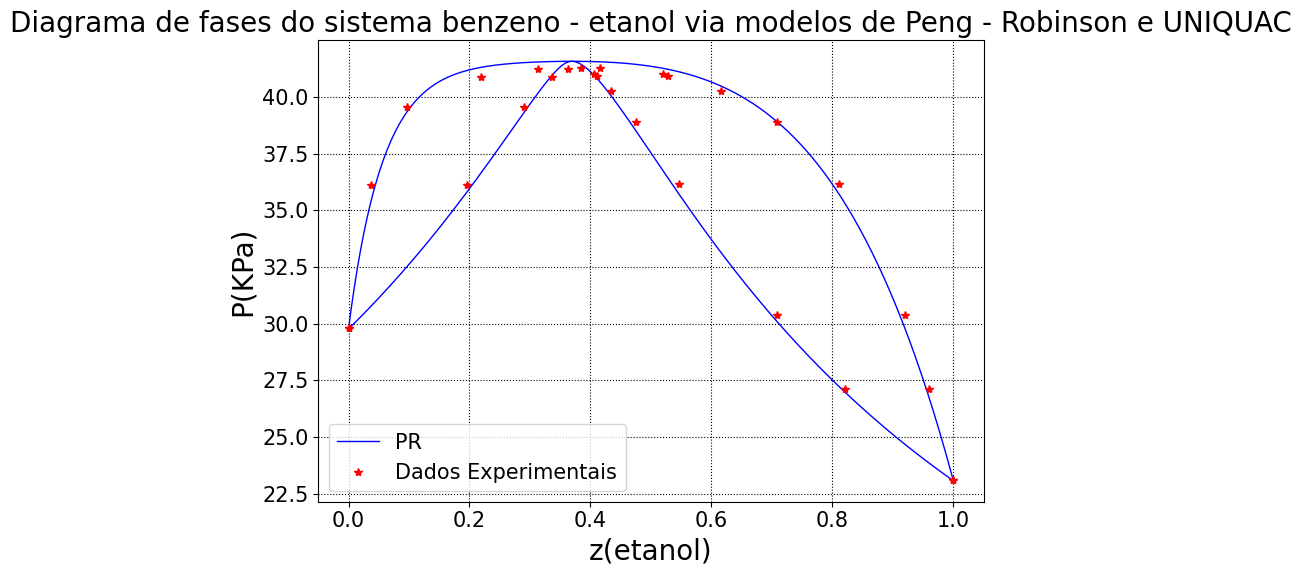

In [133]:
plt.figure(figsize=(8,6))
plt.plot(zcalc3,pbprcalc3/1000,color="blue", linewidth=1, label = 'PR')
plt.plot(ycalc3,pbprcalc3/1000,color="blue", linewidth=1)
plt.plot(zexp3,pexp3/1000,color="red", marker = "*", linewidth=0, label = 'Dados Experimentais')
plt.plot(yexp3,pexp3/1000,color="red", marker = "*", linewidth = 0)
plt.xlabel('z(etanol)',fontsize=20)
plt.ylabel('P(KPa)',fontsize=20)
plt.title('Diagrama de fases do sistema benzeno - etanol via modelos de Peng - Robinson e UNIQUAC', fontsize = 20)
plt.rcParams.update({'font.size':15})
plt.legend()
plt.grid(True, color='k', linestyle=':')
plt.tight_layout()
plt.savefig('ELV Benzeno-Etanol.png',dpi=600)
plt.show()

In [134]:
dadoselv3 = CarMat("dadoselv - benzeno - etanol.txt") #dados sem componentes puros
dadoselv3 = strAFloatMat(dadoselv3)
pexp3  = np.array(dadoselv3[:,0])*1000
zexp3 = dadoselv3[:,1]
yexp3 = np.array(dadoselv3[:,2])

In [135]:
#Cálculo dos erros médios em Pb e composição da fase vapor
ncomp=2

nexp3=len(zexp3)

vpexp3=[float(x) for x in pexp3] #criando um vetor numérico (string para float)
vyexp3=[float(x) for x in yexp3]

erropb  = np.zeros(nexp3)
erroyb = np.zeros(nexp3)

erromediopb=0;
erromedioyb=0;

for i in range(nexp3):
    z=[zexp3[i],1-zexp3[i]]
    pbpr,yb=calcpbreal(z,t,pv3,fsat3,vTcPcw3,vlambda3,mrq3,xf,ncomp)
    ybpr = yb[0]
    erropb[i]=abs(vpexp3[i]-pbpr)/vpexp3[i]
    erroyb[i]=abs(vyexp3[i]-ybpr)/vyexp3[i]
    erromediopb=erromediopb+erropb[i]
    erromedioyb=erromedioyb+erroyb[i]

erromediopb=erromediopb/nexp3
erromedioyb=erromedioyb/nexp3

print('erro medio Pb=',erromediopb)
print('erro medio yb=',erromedioyb)

erro medio Pb= 0.008934607690567021
erro medio yb= 0.02222325609845754
